### Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.animation import FuncAnimation, PillowWriter
from matplotlib.colors import LinearSegmentedColormap
from sklearn.datasets import make_s_curve

from specmf.models import Graph, MultiFidelityModel

In [2]:
%%html
<style type='text/css'>
.CodeMirror{
font-size: 18px;
</style>

In [3]:
plt.rcParams.update({
    "figure.facecolor": (0, 0, 0, 0),   # Transparent
    "axes.facecolor":   (0, 0, 0, 0),   # Transparent
    "savefig.facecolor": (0, 0, 0, 0),  # Transparent when saving
    "axes.labelcolor":  "white",
    "axes.edgecolor":   "white",
    "axes.titlecolor":  "white",
    "xtick.color":      "white",
    "ytick.color":      "white",
    # "ztick.color":      "white",
})

plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "cm"

lf_color = "navajowhite"
hf_color = "red"
mf_color = "lime"

def make_3d_white(ax, color = (0.4, 0.4, 0.4, 1)):
    """
    Style a 3D axis for dark/transparent background:
    - transparent panes
    - white grid and tick labels
    """
    # Transparent panes
    ax.xaxis.set_pane_color(color)
    ax.yaxis.set_pane_color(color)
    ax.zaxis.set_pane_color(color)

    # White grid lines
    for axis in (ax.xaxis, ax.yaxis, ax.zaxis):
        if hasattr(axis, "_axinfo"):
            axis._axinfo["grid"]["color"] = "white"

    # White tick labels & ticks
    ax.tick_params(colors="white")

### Get some data

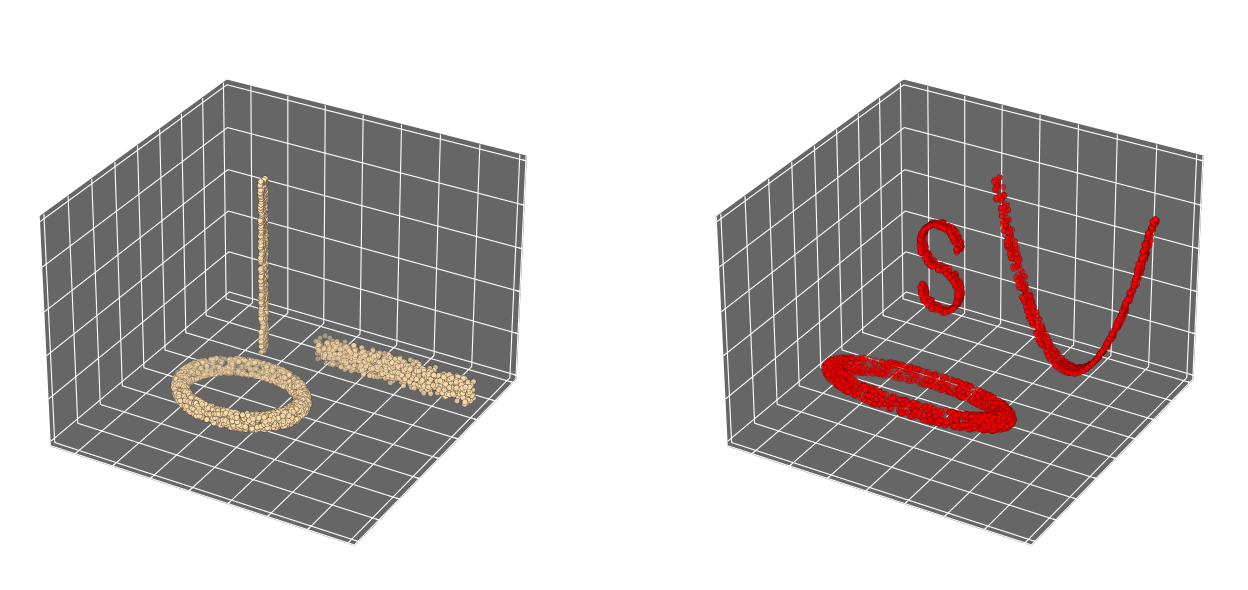

In [4]:
def make_s_cluster(n=500, noise=0.01, random_state=0, return_t=False):
    """
    3D S-shaped cluster based on sklearn's make_s_curve.
    We keep the parameter t so we can unfold the S in a
    smooth, monotone way for the HF data.
    """
    X, t = make_s_curve(n_samples=n, noise=noise, random_state=random_state)
    # Scale and translate to taste
    X = np.array([1.0, 0.35, 1.0]) * X + np.array([0.0, 2.5, 5.0])

    if return_t:
        return X, t
    return X


def make_torus_cluster(n=1000, R=3.0, r=0.35, noise=0.01, random_state=0):
    """
    3D torus cluster.

    R: major radius (distance from center of hole to center of tube)
    r: minor radius (radius of tube)
    """
    rng = np.random.RandomState(random_state)
    u = rng.uniform(0, 2 * np.pi, n)
    v = rng.uniform(0, 2 * np.pi, n)

    x = (R + r * np.cos(v)) * np.cos(u)
    y = (R + r * np.cos(v)) * np.sin(u)
    z = r * np.sin(v)

    X = np.column_stack([x, y, z])
    X += noise * rng.randn(n, 3)

    X[:, 0] *= 1.5
    X[:, 1] *= 0.6

    return X


def make_half_moon_cluster(
    n=500,
    length=8.0,
    r_max=0.5,
    center=(6.0, 5.0, 1.0),
    random_state=0,
):
    """
    Generate a straight 'cylinder-like' point cloud.

    - Medial axis is a segment along x of total length `length`,
      centered at `center`.
    - Around the medial axis, add uniform noise in y and z in
      [-r_max, r_max].

    This is the 'straight' configuration – you can treat this as LF.
    """
    rng = np.random.RandomState(random_state)
    cx, cy, cz = center

    # Coordinate along the medial axis (x-direction), centered at cx
    s = rng.uniform(-0.5, 0.5, n) * length   # axis parameter in [-L/2, L/2]

    # Straight medial axis
    x = cx + s

    # Uniform noise around the axis in y, z
    # (change to [0, r_max] if you want only one side)
    y = cy + rng.uniform(-r_max, r_max, n)
    z = cz + rng.uniform(-r_max, r_max, n)

    X = np.column_stack([x, y, z])

    return X


# ======================================================
#   UNFOLDING TRANSFORMS
# ======================================================

def unfold_s_curve(X, t, length=8.0):
    """
    Unfold the S-curve into a straight vertical curtain:
    - Preserve ordering via parameter t.
    - Keep the center of mass fixed in x,z.
    - Keep y (height) as in the original so the 'vertical'
      structure at the beginning stays vertical.

    Result: a straight band aligned mainly along z, centered
    where the S originally was.
    """
    center = X.mean(axis=0)  # (cx, cy, cz)

    # Normalize t to [-0.5, 0.5]
    t_norm = (t - t.min()) / (t.max() - t.min()) - 0.5

    # Map to a straight line in z, keep y from original, fix x at center
    x_new = np.full_like(t_norm, center[0])
    y_new = X[:, 1]  # keep vertical structure
    z_new = center[2] - length * t_norm

    return np.column_stack([x_new, y_new, z_new])


def bend_half_moon(X, center=(6.0, 5.0, 1.0)):
    """
    Bend a straight cylinder into a 'half-moon'-like shape by
    squaring the y-coordinate w.r.t. the center.

    For each point:
        d = X - center
        d_y_new = d_y ** 2
        X_bent = center + (d_x, d_y_new, d_z)

    This gives a smooth, deterministic mapping LF -> HF.
    """
    center = np.asarray(center, dtype=float)
    d = X - center

    # Square the second component (y) w.r.t. the center
    d[:, 2] = 0.5 * d[:, 0] ** 2

    X_bent = d + center
    return X_bent


# ======================================================
#   GENERATE LF + HF
# ======================================================

def generate_lf_hf_example(
    n_s=600,
    n_torus=1500,
    n_halfmoon=800,
    random_state=0
):
    """
    Generate low-fidelity (LF) and transformed high-fidelity (HF)
    datasets with 3 clusters: S-shape, torus, and half-moon.

    LF:
      - S-curve (make_s_curve)
      - Torus
      - Half-moon

    HF:
      - Torus: stretched in y, shrunk in x
      - S-curve: unfolded into a vertical straight 'curtain'
      - Half-moon: opened into a horizontal straight segment
    """
    # --- LF clusters ---
    s_hf, t_s = make_s_cluster(n=n_s, random_state=random_state, return_t=True)
    torus_hf = make_torus_cluster(n=n_torus, random_state=random_state + 1)
    half_lf = make_half_moon_cluster(n=n_halfmoon, random_state=random_state + 2)
    half_hf = bend_half_moon(half_lf)

    hf_data = np.vstack([s_hf, torus_hf, half_hf])
    labels = np.hstack([
        np.zeros(len(s_hf), dtype=int),
        np.ones(len(torus_hf), dtype=int),
        2 * np.ones(len(half_hf), dtype=int)
    ])

    # --- HF transformations ---

    # 1) S-curve: unfold using parameter t
    s_lf = unfold_s_curve(s_hf, t_s, length=8.0)

    # 2) Torus: stretch x, shrink y
    torus_lf = torus_hf.copy()
    torus_center = torus_hf.mean(axis=0)
    torus_lf = torus_lf - torus_center
    torus_lf[:, 0] /= 1.5
    torus_lf[:, 1] /= 0.6
    torus_lf += torus_center

    # 3) Half-moon: unfold using theta

    lf_data = np.vstack([s_lf, torus_lf, half_lf])

    return lf_data, hf_data, labels


# ======================================================
#   TEST + PLOT
# ======================================================

lf_data, hf_data, labels = generate_lf_hf_example()

fig = plt.figure(figsize=(14, 6))

ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax1.set_title("Low-fidelity data", fontsize=20)
sc1 = ax1.scatter(
    lf_data[:, 0], lf_data[:, 1], lf_data[:, 2],
    c=lf_color, s=15, edgecolor="black", linewidth=0.2
)


ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.set_title("High-fidelity data", fontsize=20)
sc2 = ax2.scatter(
    hf_data[:, 0], hf_data[:, 1], hf_data[:, 2],
    c=hf_color, s=15, edgecolor="black", linewidth=0.2
)

for ax in (ax1, ax2):
    ax.set_xlabel(r"$u_1$", fontsize=18)
    ax.set_ylabel(r"$u_2$", fontsize=18)
    ax.set_zlabel(r"$u_3$", fontsize=18)
    ax.axis("equal")
    ax.set_xlim(-5, 10)
    ax.set_ylim(-10, 10)
    ax.set_zlim(0, 10)

make_3d_white(ax1)
make_3d_white(ax2)

plt.tight_layout()

#### Use a `MultiFidelityModel`

In [5]:
## Multi fidelity model

# Only a small set of high-fidelity data (10 points) is used to train the model. 
# The rest of the high-fidelity data is used for visual validation only.
n_lf = lf_data.shape[0]
n_hf = 40
noise_scale_hf = 0.01

# Create the graph
graph_config = {
    'metric': 'euclidean',
    'dist_space': 'ambient',
    'method': 'full',
    'corr_scale': None,
    'k_adj': 11,
    'p': 0.5,
    'q': 0.5,
}

graph_lf = Graph(
    data=lf_data,
    **graph_config,
)

#### High-fidelity data acquisition strategy based on spectral clustering

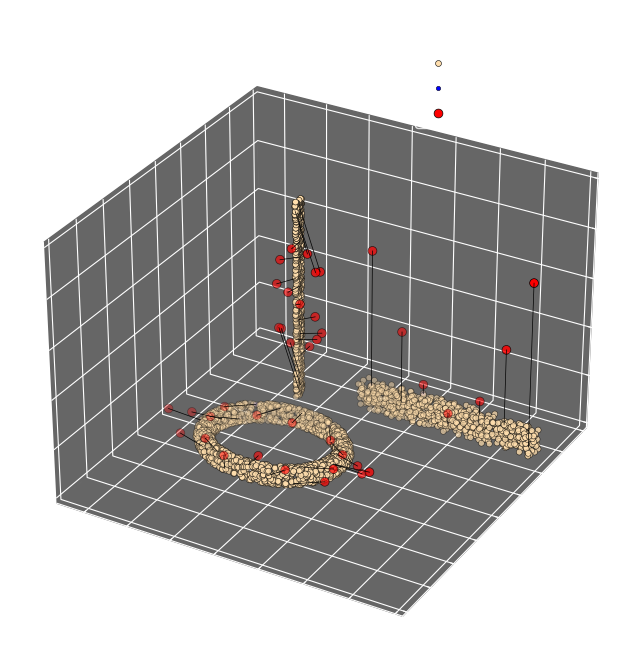

In [6]:
## Perform clustering on the graph to find the high-fidelity indices
inds_centroids, labels = graph_lf.cluster(n=n_hf)

fig = plt.figure(figsize=(8, 8))
ax1 = fig.add_subplot(1, 1, 1, projection='3d')
ax1.scatter(
    lf_data[:, 0], lf_data[:, 1], lf_data[:, 2],
    c=lf_color, label='Low-fidelity data',
    s=18, edgecolor="black", linewidth=0.4
)

ax1.scatter(
    lf_data[inds_centroids, 0], lf_data[inds_centroids, 1], lf_data[inds_centroids, 2], 
    color='blue', s=10, label='Selected LF data',
    edgecolor="black", linewidth=0.35, zorder=10
)
ax1.scatter(
    hf_data[inds_centroids, 0], hf_data[inds_centroids, 1], hf_data[inds_centroids, 2], 
    color=hf_color, s=40, label='HF training data',
    edgecolor="black", linewidth=0.5, zorder=10
)

for i in range(n_hf):
    ax1.plot(
        [lf_data[inds_centroids[i], 0], hf_data[inds_centroids[i], 0]],
        [lf_data[inds_centroids[i], 1], hf_data[inds_centroids[i], 1]],
        [lf_data[inds_centroids[i], 2], hf_data[inds_centroids[i], 2]],
        color='k', linewidth=0.5, zorder=10
    )

ax1.legend(
    facecolor="none",
    edgecolor="white",
    labelcolor="white",
    fontsize=12
)

ax1.set_title("Low-fidelity data", fontsize=20)
ax1.set_xlabel(r"$u_1$", fontsize=18)
ax1.set_ylabel(r"$u_2$", fontsize=18)
ax1.set_zlabel(r"$u_3$", fontsize=18)
ax1.set_xlim(-5, 10)
ax1.set_ylim(-10, 10)
ax1.set_zlim(0, 10)

make_3d_white(ax1)

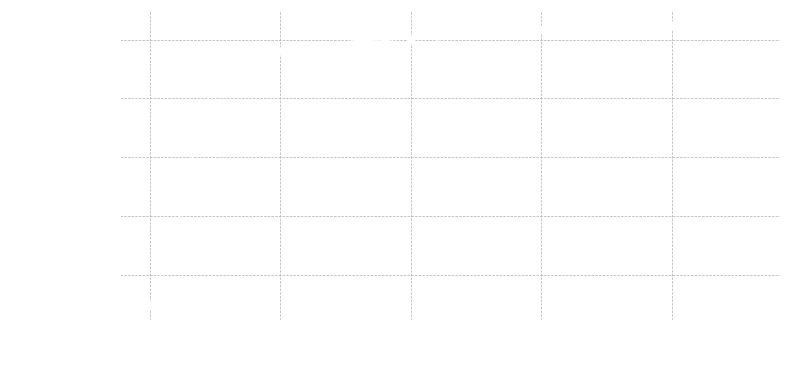

In [7]:
# Plot Laplacian spectrum
eigvals, eigvecs = graph_lf.laplacian_eig()

def plot_spectrum(eigvals: np.ndarray, n: int) -> None:
    fig, ax = plt.subplots(1, 1, figsize=(8, 4))
    ax.plot(
        np.arange(1, n + 1), np.abs(eigvals[:n]), "o-", c="white", markersize=5
    )
    ax.set_yscale("log")
    ax.set_xticks(range(1, n + 1, 5))
    ax.tick_params(axis="both", labelsize=14)
    ax.set_xlabel("$m$", fontsize=20)
    ax.set_ylabel(r"$\lambda_m$", fontsize=20, rotation=0, labelpad=20)
    ax.grid(True, linestyle="--", linewidth=0.5)
    plt.tight_layout()

plot_spectrum(eigvals, 24)

In [8]:
## Aquire high-fidelity data at the centroids location
hf_data_train = hf_data[inds_centroids, :]

## Initialize the model
model_config = {
    'sigma': noise_scale_hf,
    'tau': 1e-2,
    'kappa': 0.2,
}
model = MultiFidelityModel(**model_config)

# Fit and transform to get multi-fidelity data
# This will find the value of hyperparameter kappa that leads to given level of uncertainty 
# in the multi-fidelity estimates.
# mf_data, mf_covar_mat, mf_std, loss_history, kappa_history = model.fit_transform(
#     graph_lf,
#     hf_data_train,
#     inds_centroids,
#     maxiter=200,
#     step_size=10,
#     step_decay_rate=1.01,
#     ftol=1e-6,
#     gtol=1e-8,
#     verbose=True,
# )
# plot_loss_and_kappa(loss_history, kappa_history)

mf_data, mf_covar_mat, mf_std = model.transform(
    graph_lf,
    hf_data_train,
    inds_centroids
)


# Plot the model final configuration and loss history
model.summary()


Model Configuration:
sigma              : 0.01
beta               : 2
kappa              : 0.2
omega              : 2000.0
method             : full
spectrum_cutoff    : None
tau                : 0.01


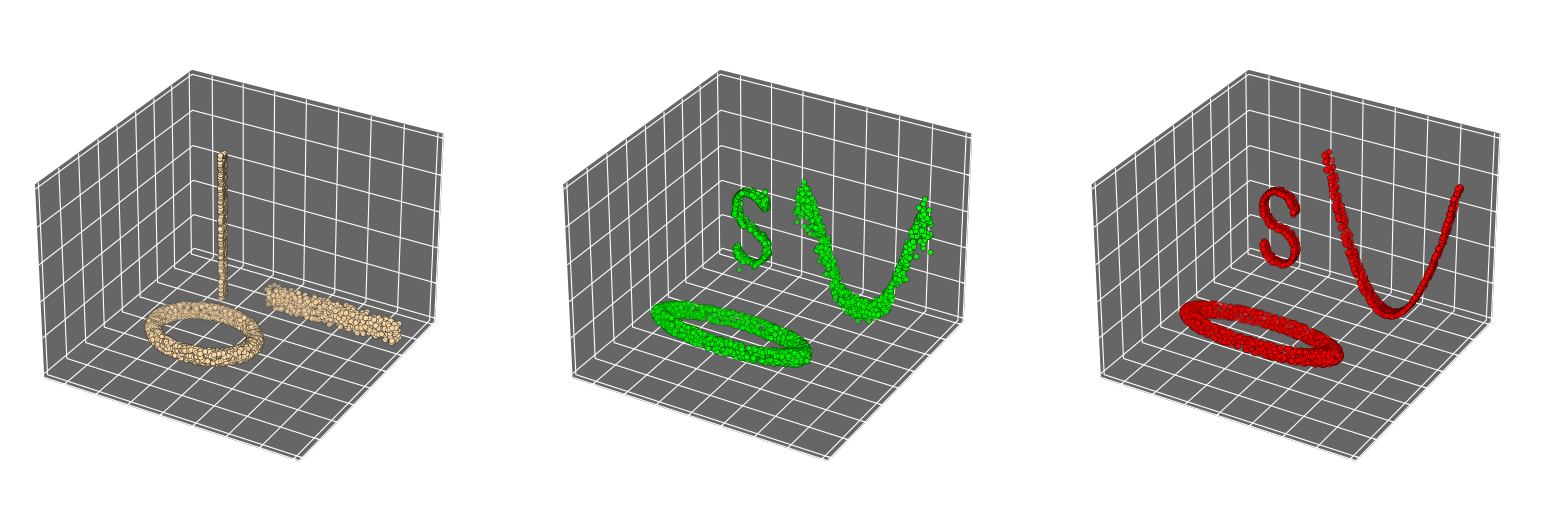

In [9]:
# Plot
fig = plt.figure(figsize=(16, 5))

# lf data
ax1 = fig.add_subplot(1, 3, 1, projection='3d')
sc1 = ax1.scatter(
    lf_data[:, 0], lf_data[:, 1], lf_data[:, 2],
    c=lf_color, s=15, edgecolor="black", linewidth=0.3
)
ax1.set_title("Low-fidelity data", fontsize=18)

# mf data
ax2 = fig.add_subplot(1, 3, 2, projection='3d')
sc2 = ax2.scatter(
    mf_data[:, 0], mf_data[:, 1], mf_data[:, 2], 
    c=mf_color, s=15, edgecolor="black", linewidth=0.3
)
ax2.set_title("Multi-fidelity data", fontsize=18)

# hf data
ax3 = fig.add_subplot(1, 3, 3, projection='3d')
sc3 = ax3.scatter(
    hf_data[:, 0], hf_data[:, 1], hf_data[:, 2],
    c=hf_color, s=15, edgecolor="black", linewidth=0.3
)
ax3.set_title("High-fidelity data", fontsize=18)

for ax in [ax1, ax2, ax3]:
    ax.set_xlabel(r"$u_1$", fontsize=16)
    ax.set_ylabel(r"$u_2$", fontsize=16)
    ax.set_zlabel(r"$u_3$", fontsize=16)
    ax.set_xlim(-5, 10)
    ax.set_ylim(-10, 10)
    ax.set_zlim(0, 10)
    make_3d_white(ax)


plt.tight_layout()
plt.show()

#### Visualize uncertainty

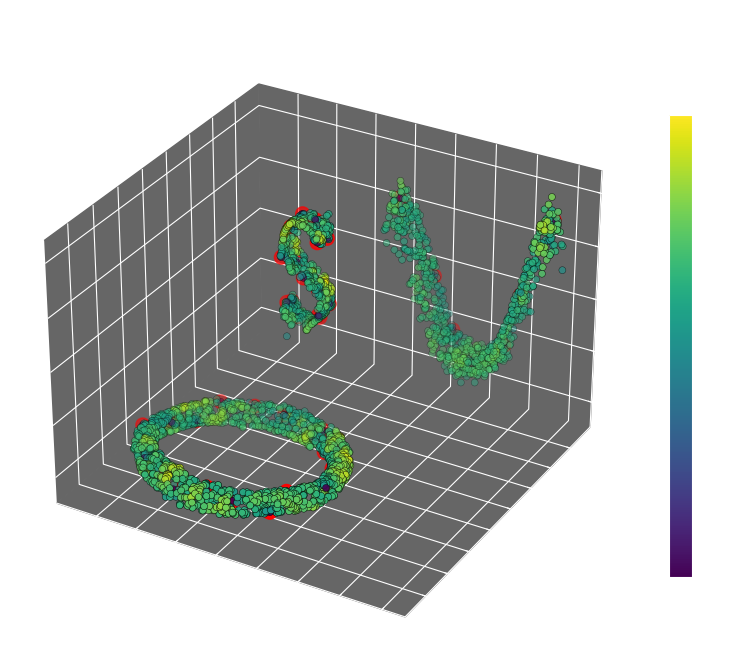

In [10]:
## Plot the standard deviation of multi-fidelity esimates

fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(1, 1, 1, projection='3d')
sc1 = ax1.scatter(
    mf_data[:, 0], mf_data[:, 1], mf_data[:, 2],
    c=mf_std, s=25, 
    edgecolor="black", linewidth=0.35
)
sc2 = ax1.scatter(
    mf_data[inds_centroids, 0], mf_data[inds_centroids, 1], mf_data[inds_centroids, 2],
    c='red', s=100, zorder=100
)
ax1.set_title("Multi-fidelity data", fontsize=18)
ax1.set_xlabel(r"$u_1$", fontsize=16)
ax1.set_ylabel(r"$u_2$", fontsize=16)
ax1.set_zlabel(r"$u_3$", fontsize=16)
fig.colorbar(sc1, ax=ax1, shrink=0.6)
make_3d_white(ax1)

#### Generate low- to multi-fidelity data transition GIF

In [11]:
n_frames = 50
n_hold_start_frame = 10
n_hold_final_frame = 20

fig = plt.figure(figsize=(16, 5))

ax1 = fig.add_subplot(1, 3, 1, projection='3d')
ax2 = fig.add_subplot(1, 3, 2, projection='3d')
ax3 = fig.add_subplot(1, 3, 3, projection='3d')

# --- Dark / transparent style for this figure ---
fig.patch.set_facecolor("black")   # or (0, 0, 0, 0) for transparent

## Left plot: Low-fidelity data with centroids and HF training points
ax1.set_title("Low-fidelity data", fontsize=18)
ax1.scatter(
    lf_data[:, 0], lf_data[:, 1], lf_data[:, 2], 
    color=lf_color, s=15, edgecolor="black", linewidth=0.35
)

ax1.set_xlabel(r"$u_1$", fontsize=16)
ax1.set_ylabel(r"$u_2$", fontsize=16)
ax1.set_zlabel(r"$u_3$", fontsize=16)


## Middle plot: Multi-fidelity data (animated)
ax2 = fig.add_subplot(1, 3, 2, projection='3d')
ax2.set_title("Multi-fidelity data", fontsize=18)
ax2.set_xlabel(r"$u_1$", fontsize=16)
ax2.set_ylabel(r"$u_2$", fontsize=16)
ax2.set_zlabel(r"$u_3$", fontsize=16)

# Initialize scatter plots for animation
scat = ax2.scatter(
    lf_data[:, 0], lf_data[:, 1], lf_data[:, 2],
    s=15, color=lf_color, edgecolor="black", linewidth=0.35
)

scat_centroids = ax2.scatter(
    lf_data[inds_centroids, 0], lf_data[inds_centroids, 1], lf_data[inds_centroids, 2],
    s=15, color='blue', edgecolor="black", linewidth=0.35
)
scat_hf_train = ax2.scatter(
    hf_data_train[:, 0], hf_data_train[:, 1], hf_data_train[:, 2],
    color=hf_color, s=25, edgecolor="black", linewidth=0.35
)

# Create lines connecting centroids to HF training points
lines_3d = []
for i in range(len(inds_centroids)):
    line, = ax2.plot(
        [lf_data[inds_centroids[i], 0], hf_data_train[i, 0]],
        [lf_data[inds_centroids[i], 1], hf_data_train[i, 1]],
        [lf_data[inds_centroids[i], 2], hf_data_train[i, 2]],
        color='black',
        linewidth=1,
    )
    lines_3d.append(line)

## Right plot: High-fidelity data
ax3 = fig.add_subplot(1, 3, 3, projection='3d')
ax3.set_title("High-fidelity data", fontsize=18)
ax3.scatter(
    hf_data[:, 0], hf_data[:, 1], hf_data[:, 2], 
    s=15, color=hf_color, edgecolor="black", linewidth=0.35
)
ax3.set_xlabel(r"$u_1$", fontsize=16)
ax3.set_ylabel(r"$u_2$", fontsize=16)
ax3.set_zlabel(r"$u_3$", fontsize=16)

for ax in (ax1, ax2, ax3):
    ax.set_facecolor("black")      # pane background
    ax.tick_params(colors="white")
    ax.xaxis.label.set_color("white")
    ax.yaxis.label.set_color("white")
    ax.zaxis.label.set_color("white")
    ax.title.set_color("white")
    make_3d_white(ax)

plt.tight_layout()

# Color map for transition
colors = [(1.0, 0.870588, 0.678431), (0, 1.0, 0)]  # RGB for navajowhite to lime
custom_cmap = LinearSegmentedColormap.from_list("orange_lime", colors, N=25)

def update(frame):
    if frame < n_frames:
        t = frame / n_frames

        # Interpolate data from LF to MF
        interpolated_data = (1 - t) * lf_data + t * mf_data
        scat._offsets3d = (interpolated_data[:, 0], interpolated_data[:, 1], interpolated_data[:, 2])

        # Interpolate centroids from LF to HF
        interpolated_centroids = (1 - t) * lf_data[inds_centroids] + t * hf_data_train
        scat_centroids._offsets3d = (
            interpolated_centroids[:, 0], interpolated_centroids[:, 1], interpolated_centroids[:, 2]
        )

        # Update color
        color_value = custom_cmap(t)
        scat.set_color(color_value)
        # Add edge color
        scat.set_edgecolor('black')
        scat.set_linewidth(0.35)

        # Update lines
        for i, line in enumerate(lines_3d):
            line.set_data_3d(
                [interpolated_centroids[i, 0], hf_data_train[i, 0]],
                [interpolated_centroids[i, 1], hf_data_train[i, 1]],
                [interpolated_centroids[i, 2], hf_data_train[i, 2]]
            )
    return scat, scat_centroids, scat_hf_train, *lines_3d

def frame_generator(total_frames):
    for _ in range(n_hold_start_frame):
        yield 0  # First frame
    yield from range(n_frames)
    for _ in range(n_hold_final_frame):
        yield n_frames - 1  # Last frame

total_frames = n_frames + n_hold_start_frame + n_hold_final_frame

anim = FuncAnimation(
    fig, update,
    frames=frame_generator(total_frames),
    interval=200,
    blit=False,
    cache_frame_data=False,
)

anim.save(
    "example-transition-3d.gif",
    writer=PillowWriter(fps=10),
    savefig_kwargs={"facecolor": "black"}
)


plt.close(fig)
print("Animation saved as 'example-transition-3d.gif'")

Animation saved as 'example-transition-3d.gif'


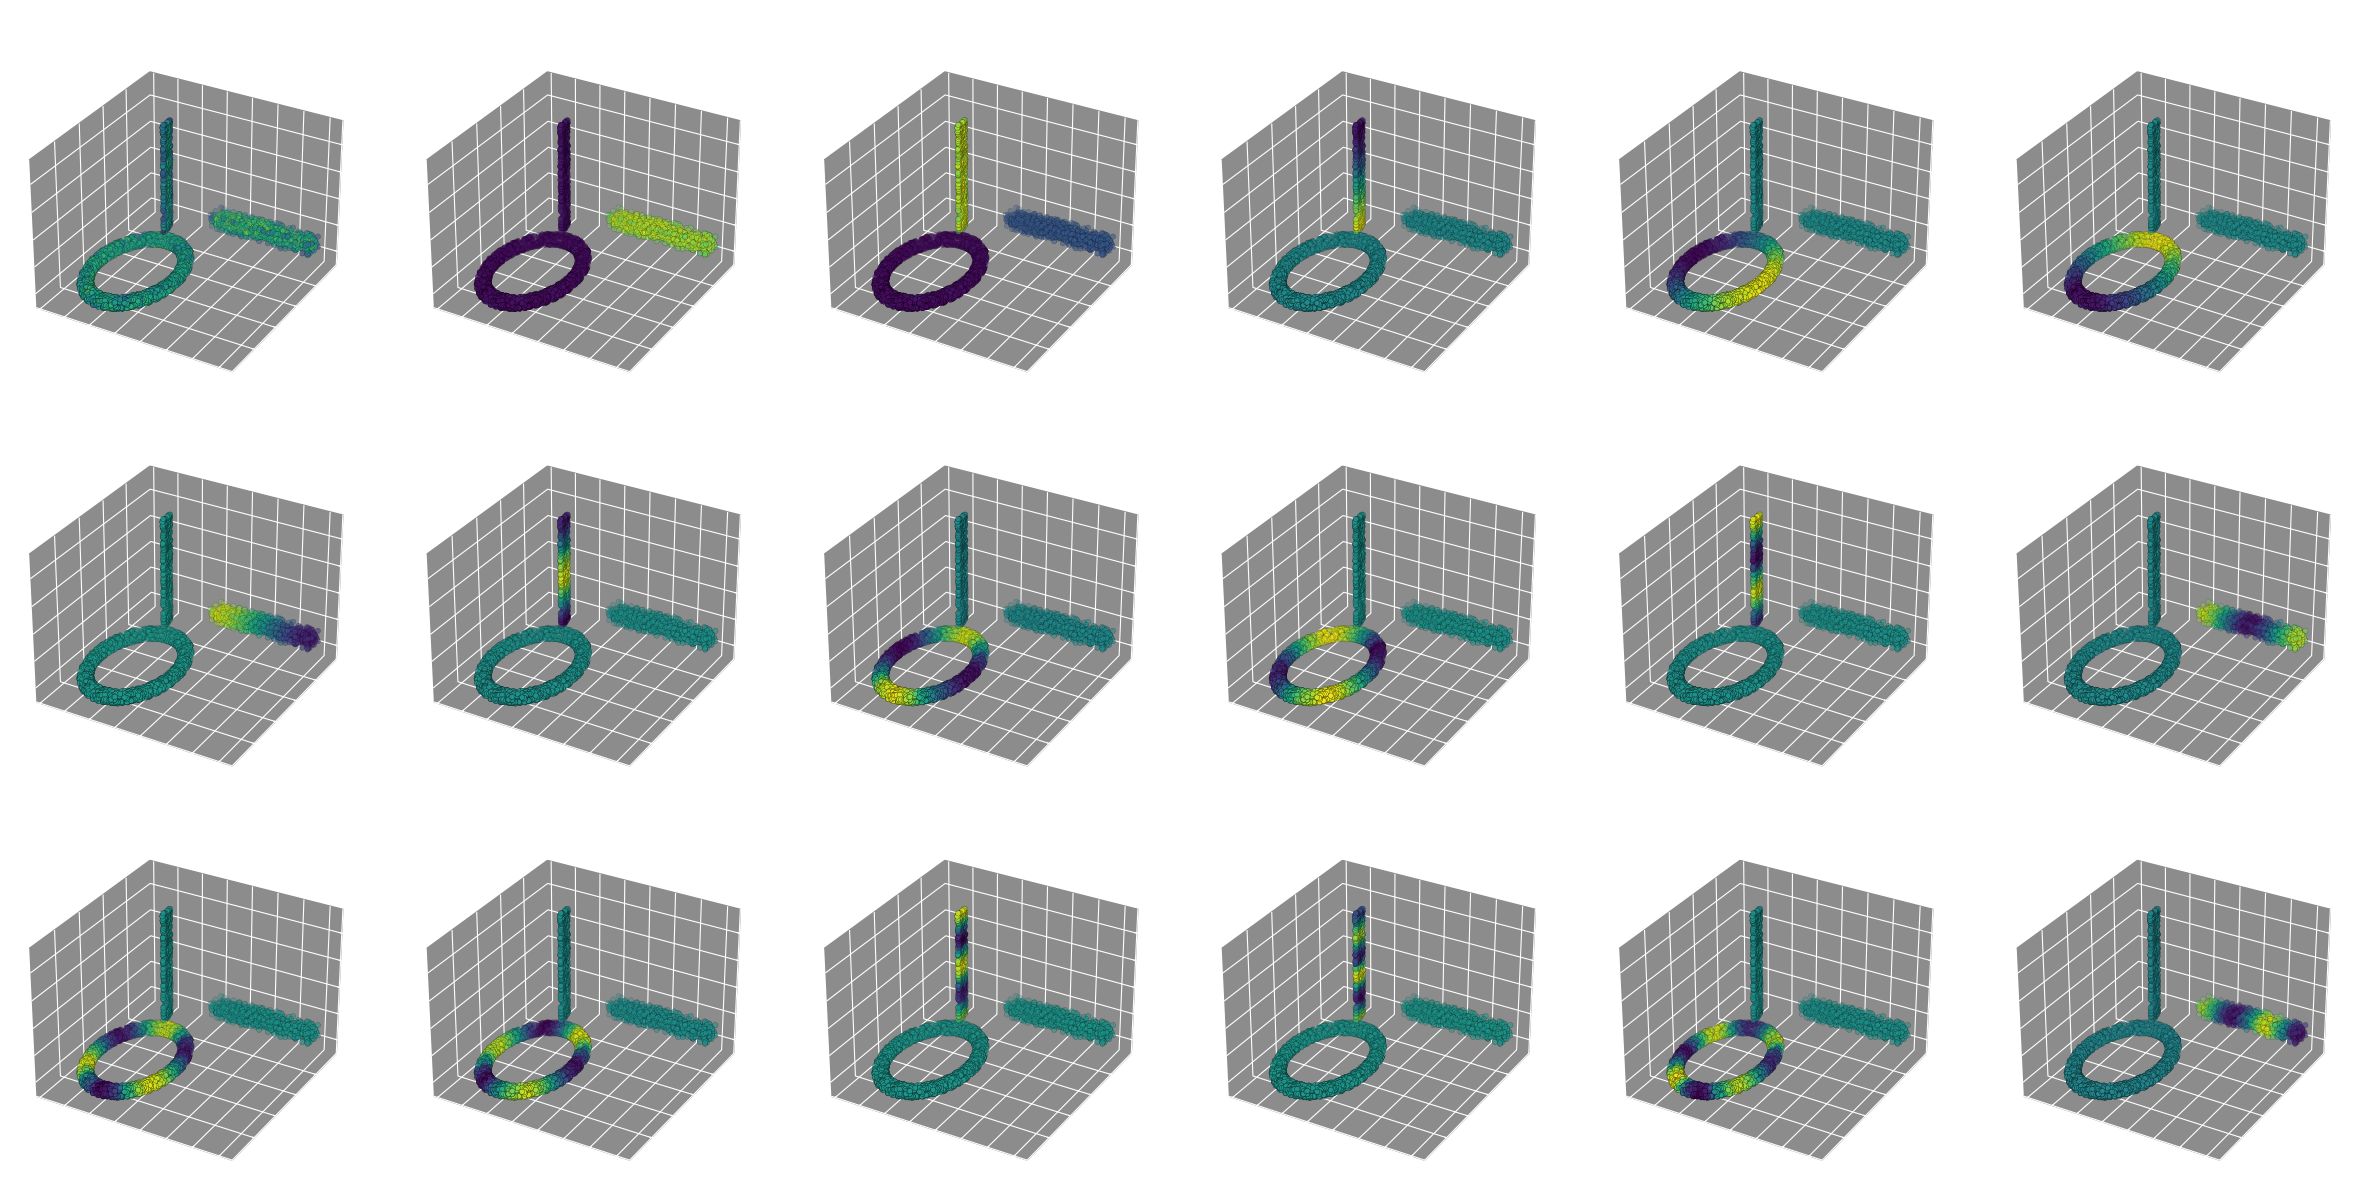

In [12]:
# Plot eigenfunctions

eigvals, eigvecs = graph_lf.laplacian_eig()

fig = plt.figure(figsize=(24, 12))

for i in range(18):
    eig_ind = i
    ax = fig.add_subplot(3, 6, i + 1, projection='3d')
    ax.set_title(fr'$\psi_{{{eig_ind + 1}}}$', fontsize=24)

    sc = ax.scatter(
        lf_data[:, 0], lf_data[:, 1], lf_data[:, 2],
        s=15, c=eigvecs[:, eig_ind],
        edgecolor="black", linewidth=0.2
    )

    # ax.set_xlabel(r"$u_1$", fontsize=14)
    # ax.set_ylabel(r"$u_2$", fontsize=14)
    # ax.set_zlabel(r"$u_3$", fontsize=14)
    # ax.tick_params(labelsize=0)
    ax.grid(True)
    make_3d_white(ax, color = (0.55, 0.55, 0.55, 1))

# Incease verticla space between subplots
fig.subplots_adjust(hspace=0.15, wspace=0.15)

plt.tight_layout()
plt.show()

In [13]:
graph_lf.cluster(n=3)
labels = graph_lf.labels

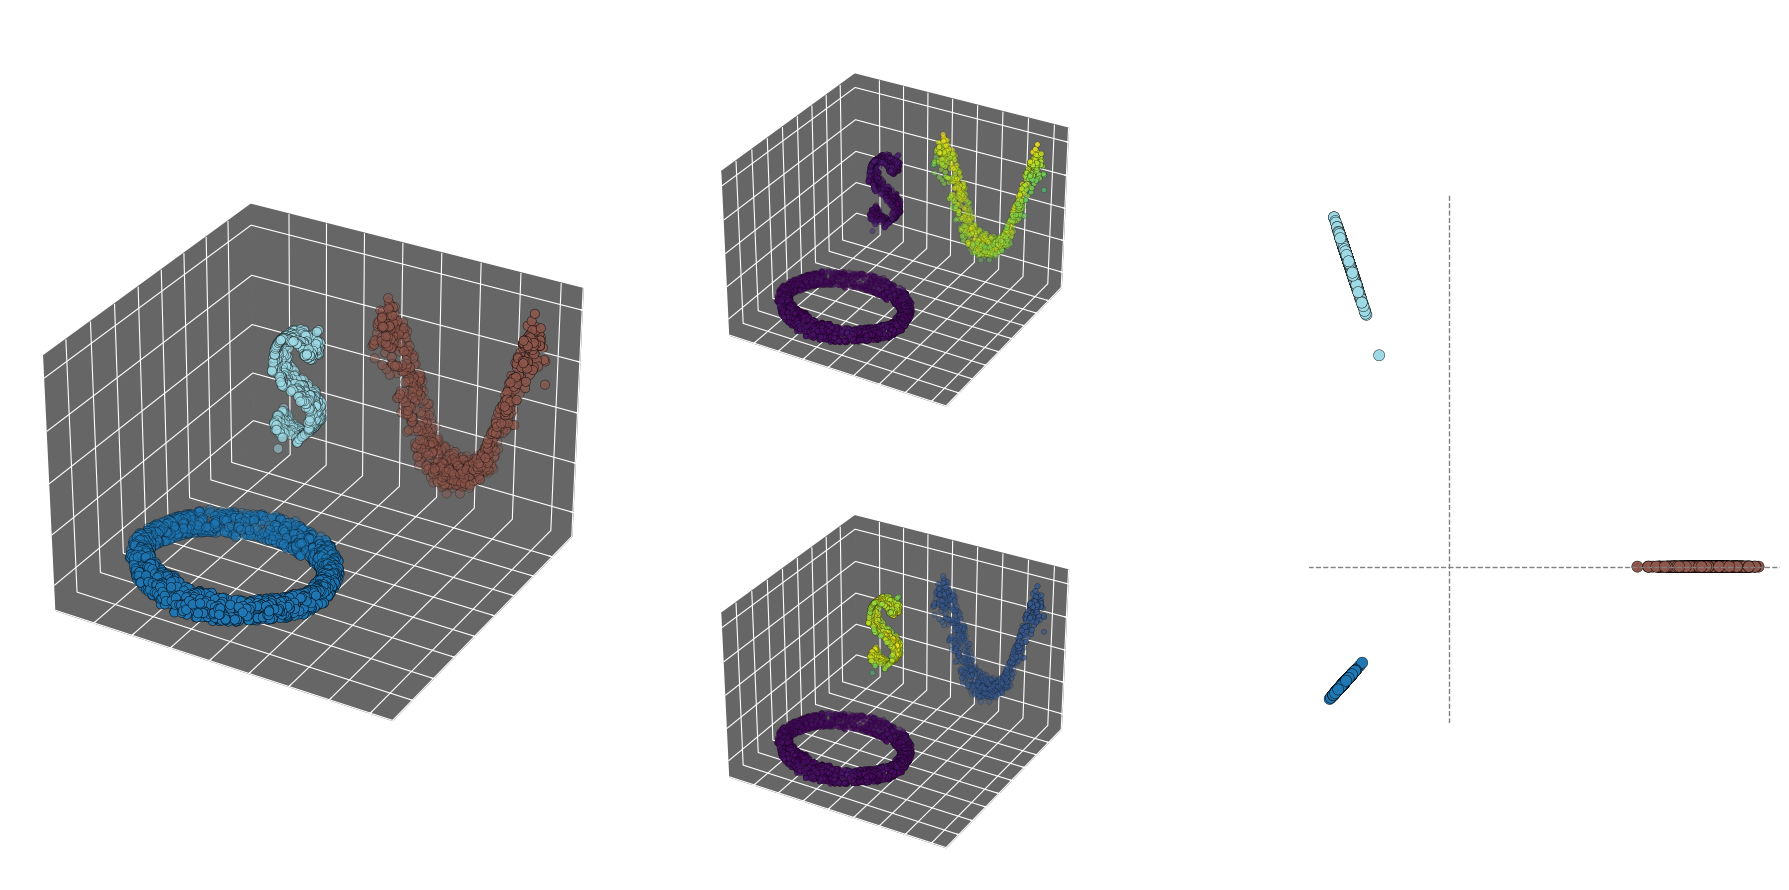

In [14]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(18, 9))
gs = GridSpec(2, 4, width_ratios=[1.4, 0.9, 0.1, 1.1], figure=fig)

# =====================
# Left: 3D LF data, colored by cluster labels
# =====================
ax1 = fig.add_subplot(gs[:, 0], projection='3d')
sc1 = ax1.scatter(
    mf_data[:, 0], mf_data[:, 1], mf_data[:, 2],
    c=labels, s=45,
    cmap='tab20',
    edgecolor="black", linewidth=0.35
)
ax1.set_title("Data", fontsize=24)
ax1.set_xlabel(r"$u_1$", fontsize=22)
ax1.set_ylabel(r"$u_2$", fontsize=22)
ax1.set_zlabel(r"$u_3$", fontsize=22)
make_3d_white(ax1)


# =====================
# Middle-top: 3D data colored by ψ1
# =====================
ax_mid_top = fig.add_subplot(gs[0, 1], projection='3d')
sc_psi1 = ax_mid_top.scatter(
    mf_data[:, 0], mf_data[:, 1], mf_data[:, 2],
    s=15, c=eigvecs[:, 1],
    edgecolor="black", linewidth=0.2
)
ax_mid_top.set_title(r"$\psi_1$", fontsize=24)
make_3d_white(ax_mid_top)
ax_mid_top.set_xlabel(r"$u_1$", fontsize=16)
ax_mid_top.set_ylabel(r"$u_2$", fontsize=16)
ax_mid_top.set_zlabel(r"$u_3$", fontsize=16)

# =====================
# Middle-bottom: 3D data colored by ψ2
# =====================
ax_mid_bot = fig.add_subplot(gs[1, 1], projection='3d')
sc_psi2 = ax_mid_bot.scatter(
    mf_data[:, 0], mf_data[:, 1], mf_data[:, 2],s=15,
    c=eigvecs[:, 2],
    edgecolor="black", linewidth=0.2
)
ax_mid_bot.set_title(r"$\psi_2$", fontsize=24)
make_3d_white(ax_mid_bot)
ax_mid_bot.set_xlabel(r"$u_1$", fontsize=16)
ax_mid_bot.set_ylabel(r"$u_2$", fontsize=16)
ax_mid_bot.set_zlabel(r"$u_3$", fontsize=16)

# =====================
# Right: 2D spectral embedding
# =====================
ax2 = fig.add_subplot(gs[:, 3])
sc_embed = ax2.scatter(
    eigvecs[:, 1], eigvecs[:, 2],
    c=labels,
    cmap='tab20',
    s=65,
    edgecolor="black",
    linewidth=0.3,
)
ax2.set_xlabel(r"$\psi_1$", fontsize=24)
ax2.set_ylabel(r"$\psi_2$", fontsize=24, rotation=0)
ax2.set_title("Spectral embedding", fontsize=24)

ax2.axhline(0, color="gray", linewidth=1, linestyle="--")
ax2.axvline(0, color="gray", linewidth=1, linestyle="--")
ax2.set_aspect("equal", "box")

plt.tight_layout()
plt.show()